In [1]:
import os as os
import pandas as pd
import numpy as np
from matplotlib import pyplot



In [2]:
reportsPath =  os.path.abspath("..\\bin\\Debug\\netcoreapp3.1\\reports\\countries")


In [3]:
countries_list = ["Italy", "Russia", "Germany"]

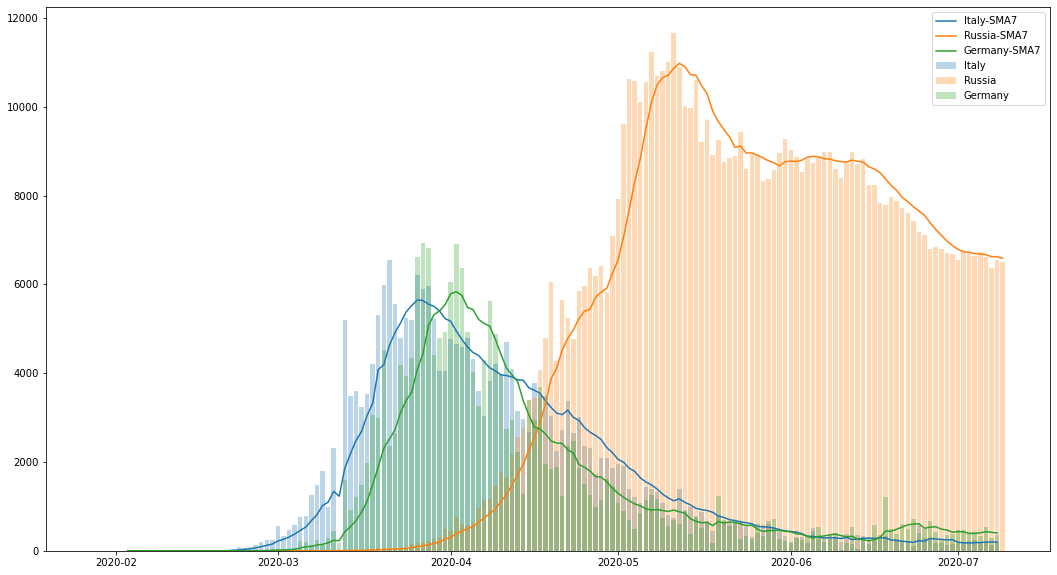

In [4]:

pyplot.figure(figsize=(18,10))

ax = pyplot.subplot(111)
ax.xaxis_date()

for country in countries_list:
    report_file = os.path.join(reportsPath,country,country+".csv")
    country_df = pd.read_csv(report_file, parse_dates=["Date"], index_col = "Date", dayfirst=True)
    country_df['Confirmed_Change_SMA7'] = country_df['Confirmed_Change'].rolling(window=7).mean()

    ax.bar(country_df.index, country_df['Confirmed_Change'].values, label=country, alpha=0.3)
    ax.plot(country_df.index, country_df['Confirmed_Change_SMA7'].values, label=country + '-SMA7') 

ax.set_ylim(bottom=0)
ax.legend()
pyplot.show()


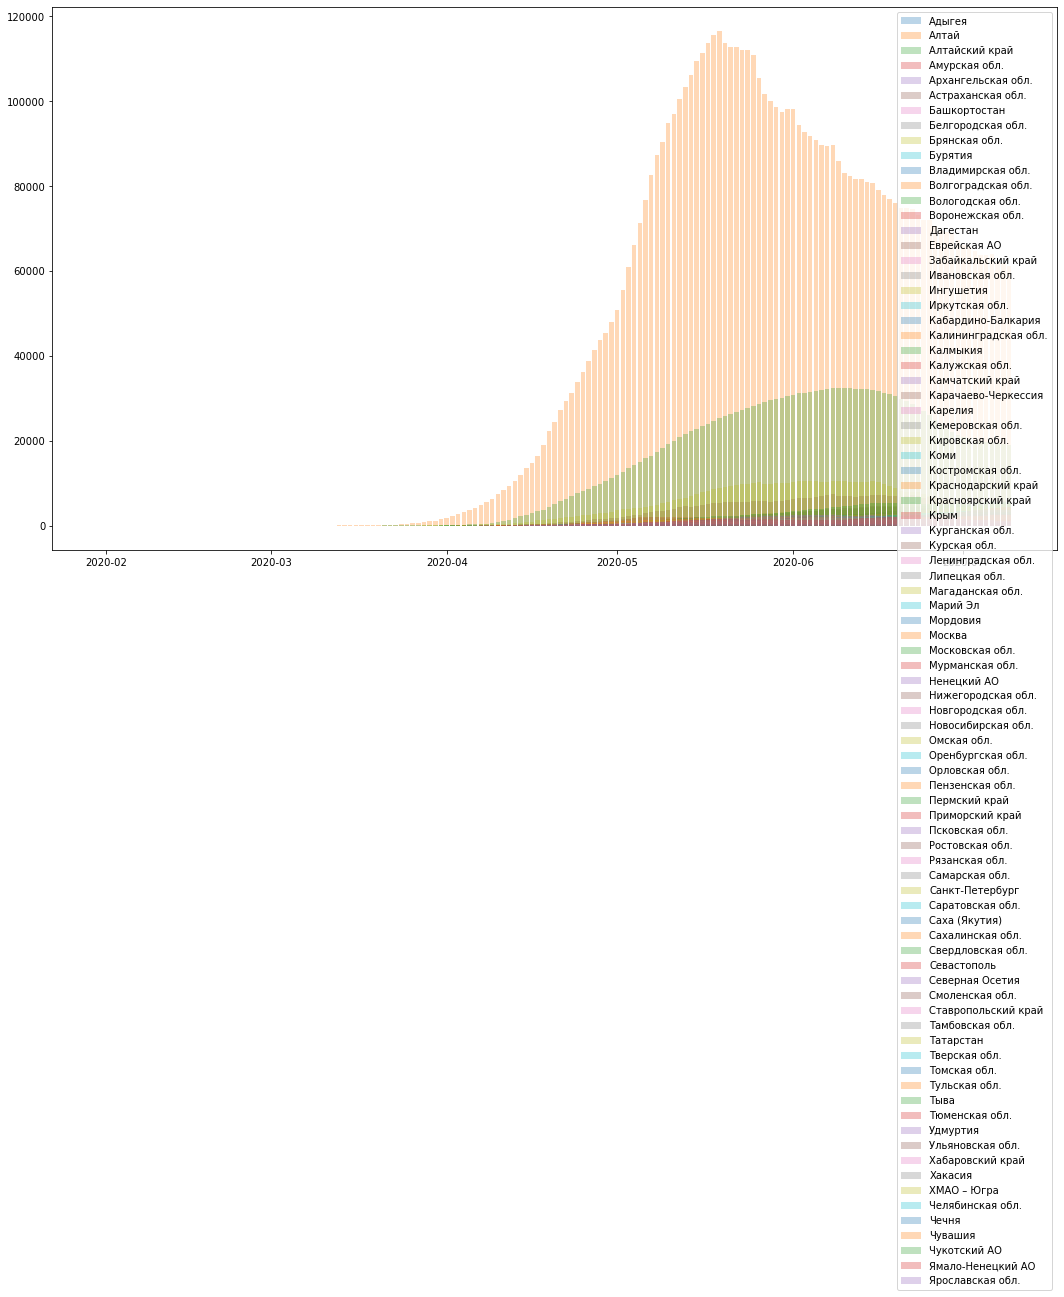

In [11]:
russiaRegions = os.path.join(reportsPath,"Russia\\regions")
region_dfs = {}
for region_report in os.listdir(russiaRegions):
    region_report_path = os.path.join(russiaRegions, region_report)
    region_df = pd.read_csv(region_report_path, parse_dates=["Date"], index_col = "Date", dayfirst=True)
    region_dfs[os.path.splitext(region_report)[0]] = region_df


pyplot.figure(figsize=(18,10))

ax = pyplot.subplot(111)
ax.xaxis_date()

for region, region_df in region_dfs.items():
    ax.bar(region_df.index, region_df['Active'].values, label=region, alpha=0.3)

#ax.set_ylim(bottom=0)
ax.legend()
pyplot.show()